1.c	

Load the data into your chosen programming language (R or python recommended). What size is your expression matrix? How many genes does it include? How much variation do you see in the data? To answer these questions, log-scale the data, calculate per-gene median expression ranges, then make a density plot showing those results. Summarize your findings.


Expr.shape: (43363, 117)
Gene medians:
 Gene
ENSG00000000003    2.494766
ENSG00000000005    0.636080
ENSG00000000419    2.659749
ENSG00000000457    1.928334
ENSG00000000460    1.699773
dtype: float64
Gene ranges:
 Gene
ENSG00000000003    0.914760
ENSG00000000005    1.207773
ENSG00000000419    0.500279
ENSG00000000457    0.400948
ENSG00000000460    0.484382
dtype: float64


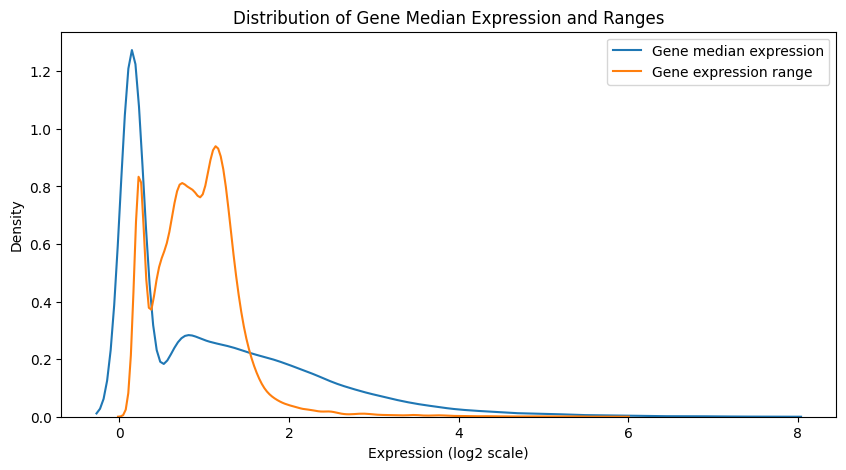

'Summary of findings\n\n'

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load gene expression and metadata into pandas dataframes
expr = pd.read_csv("data/SRP075806/SRP075806.tsv", sep='\t')
meta = pd.read_csv("data/SRP075806/metadata_SRP075806.tsv", sep='\t')

# What size is the expression matrix?
# 43363 genes and 117 samples
print("Expr.shape:", expr.shape)

# Log-transform gene data
expr = expr.set_index("Gene")
expr_log = np.log2(expr+1)

# Per-gene median
gene_medians = expr_log.median(axis=1)
print("Gene medians:\n", gene_medians.head())

# Expression ranges
gene_ranges = expr_log.max(axis=1) - expr_log.min(axis=1)
print("Gene ranges:\n", gene_ranges.head())

# Density plot
plt.figure(figsize=(10,5))
sns.kdeplot(gene_medians, label="Gene median expression")
sns.kdeplot(gene_ranges, label="Gene expression range")
plt.xlabel("Expression (log2 scale)")
plt.ylabel("Density")
plt.title("Distribution of Gene Median Expression and Ranges")
plt.legend()
plt.show()

"""Summary of findings
The distribution of gene median expressions is centered at zero and is skewed to the right. 
This means that a majority of genes with a median near zero are either lowly expressed or off.
The genes in the right tail are expressed at moderate to high rates across samples. 

The distribution of gene expression ranges is bimodal. Still, most of the ranges fall between zero to two,
meaning that most of the genes are fairly stable across samples and likely have a housekeeping-like role.
"""

2. Generate a PCA plot

In [ ]:
# Use sklearn to create the PCA plot
# 2 groups or 3?